<a href="https://colab.research.google.com/github/villeguits/Python_Exercises/blob/main/Anexo2_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

Revisa si procesamiento en GPU es posible en el computador

In [ ]:
torch.cuda.is_available()

True

<h1>Prueba red neuronal</h1>

Descarga imagenes de prueba

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


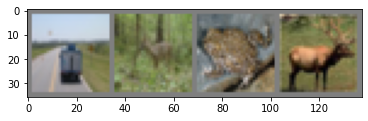

truck  deer  frog  deer


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

Creacion de red neuronal

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()


In [ ]:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
net.to(dev)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Entrenamiento del modelo

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(dev)
        labels = labels.to(dev)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.166
[1,  4000] loss: 1.855
[1,  6000] loss: 1.666
[1,  8000] loss: 1.571
[1, 10000] loss: 1.513
[1, 12000] loss: 1.466
[2,  2000] loss: 1.388
[2,  4000] loss: 1.359
[2,  6000] loss: 1.341
[2,  8000] loss: 1.330
[2, 10000] loss: 1.285
[2, 12000] loss: 1.278
Finished Training


Guardar y cargar el modelo entrenado

In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
outputs = net(images)

Predicciones y validaciones del modelo

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:   bird  bird  frog  deer


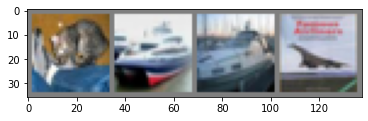

GroundTruth:    cat  ship  ship plane


In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 52.6 %
Accuracy for class car   is: 80.8 %
Accuracy for class bird  is: 70.4 %
Accuracy for class cat   is: 37.9 %
Accuracy for class deer  is: 34.4 %
Accuracy for class dog   is: 44.3 %
Accuracy for class frog  is: 54.6 %
Accuracy for class horse is: 56.7 %
Accuracy for class ship  is: 60.8 %
Accuracy for class truck is: 43.0 %


KMeans

In [ ]:
import pandas as pd

rfm = pd.read_excel('RFM_exc.xlsx')
print(rfm.columns)
print(rfm.shape)
rfm.head()

Index(['rfm_id', 'batch_id', 'customer_client_id', 'r_algorithm_config',
       'r_recency', 'r_recency_cluster_cat', 'r_recency_cluster',
       'r_frequency', 'r_frequency_cluster_cat', 'r_frequency_cluster',
       'r_credit', 'r_credit_cluster_cat', 'r_credit_cluster',
       'r_overall_score', 'r_segment_cat', 'r_segment', 'r_silhouett_score',
       'r_silhouett_k', 'r_harabasz_score', 'r_harabasz_k', 'r_bouldin_score',
       'r_bouldin_k', 'r_n_segments', 'algorithm_id',
       'r_silhouett_algorithm_id', 'r_harabasz_algorithm_id',
       'r_bouldin_algorithm_id', 'r_alg_avg', 'r_alg_coef_var',
       'r_alg_std_dev'],
      dtype='object')
(30008, 30)


,rfm_id,batch_id,customer_client_id,r_algorithm_config,r_recency,r_recency_cluster_cat,r_recency_cluster,r_frequency,r_frequency_cluster_cat,r_frequency_cluster,...,r_bouldin_score,r_bouldin_k,r_n_segments,algorithm_id,r_silhouett_algorithm_id,r_harabasz_algorithm_id,r_bouldin_algorithm_id,r_alg_avg,r_alg_coef_var,r_alg_std_dev
0,e473aa3a-ce32-401c-9aca-afeeeaef572c,16C08F6D-C3E0-4106-8CEB-DC2A249FFDEC,6227d40d-c52a-473c-9425-7f1e658e3989,NaN,0,Highly Active,4.0,59,Stellar Customer,4.0,...,1.349983,NaN,4,1a5fe2b1-1887-49d7-93a4-2ce05077276c,be815cf2-3f56-4814-bc77-50faa5cf27f4,be815cf2-3f56-4814-bc77-50faa5cf27f4,7049ac9d-4638-4646-8c33-4c5fb9d6a7b4,85.25,0.664484,56.647301
1,0faf16a9-0291-460d-9994-700bee8d639b,16C08F6D-C3E0-4106-8CEB-DC2A249FFDEC,e5aec6df-e0fb-485f-9ca6-5d3a174cd3b1,NaN,0,Highly Active,4.0,16,Regulars,3.0,...,1.349983,NaN,4,1a5fe2b1-1887-49d7-93a4-2ce05077276c,be815cf2-3f56-4814-bc77-50faa5cf27f4,be815cf2-3f56-4814-bc77-50faa5cf27f4,7049ac9d-4638-4646-8c33-4c5fb9d6a7b4,85.25,0.664484,56.647301
2,04574c3e-0ce9-436c-9f11-a7eae5fd6151,16C08F6D-C3E0-4106-8CEB-DC2A249FFDEC,4e586d56-9df7-480f-8e0b-701f5bee79a9,NaN,0,Highly Active,4.0,48,Stellar Customer,4.0,...,1.349983,NaN,4,1a5fe2b1-1887-49d7-93a4-2ce05077276c,be815cf2-3f56-4814-bc77-50faa5cf27f4,be815cf2-3f56-4814-bc77-50faa5cf27f4,7049ac9d-4638-4646-8c33-4c5fb9d6a7b4,85.25,0.664484,56.647301
3,840cb24e-d793-4139-b145-27d59247e9c1,16C08F6D-C3E0-4106-8CEB-DC2A249FFDEC,06205499-95f5-42b2-a391-6604eb0006c6,NaN,0,Highly Active,4.0,51,Stellar Customer,4.0,...,1.349983,NaN,4,1a5fe2b1-1887-49d7-93a4-2ce05077276c,be815cf2-3f56-4814-bc77-50faa5cf27f4,be815cf2-3f56-4814-bc77-50faa5cf27f4,7049ac9d-4638-4646-8c33-4c5fb9d6a7b4,85.25,0.664484,56.647301
4,2d6f86b2-18ec-4b0b-97db-2a39529f442f,16C08F6D-C3E0-4106-8CEB-DC2A249FFDEC,0ca6c6bb-8395-489b-bd15-a4e99da86dff,NaN,0,Highly Active,4.0,140,Stellar Customer,4.0,...,1.349983,NaN,4,1a5fe2b1-1887-49d7-93a4-2ce05077276c,be815cf2-3f56-4814-bc77-50faa5cf27f4,be815cf2-3f56-4814-bc77-50faa5cf27f4,7049ac9d-4638-4646-8c33-4c5fb9d6a7b4,85.25,0.664484,56.647301


In [ ]:
l = len(rfm)
xnp = rfm[['r_recency_cluster','r_frequency_cluster', 'r_credit_cluster']].dropna(how = 'any').values.reshape((-1,3))

In [ ]:
xnp

array([[4., 4., 4.],
       [4., 3., 3.],
       [4., 4., 4.],
       ...,
       [4., 2., 2.],
       [4., 2., 2.],
       [4., 2., 1.]])

In [ ]:
import torch
import numpy as np
from kmeans_pytorch import kmeans
import time

In [ ]:
# set device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)
iteraciones = 1000
paso = 10
num_clusters = 4
tol = 1e-2
max_iter = 1000

cuda


In [ ]:
# k-means cuda
deltas = []
ies = []
for i in range(1,iteraciones, paso):
    print(i)
    x = torch.from_numpy(xnp.repeat(i, axis = 0))
    print(x.shape)
    t0 = time.time()
    cluster_ids_x, cluster_centers = kmeans(
        X=x, num_clusters=num_clusters, distance='euclidean', device=device, tol = tol,max_iter = max_iter
    )
    delta = time.time() - t0
    deltas.append(delta)
    ies.append(i)
print(deltas)

1
torch.Size([341, 3])
running k-means on cuda..
Iteracion No.  0 Movimiento,  tensor(4.3064, device='cuda:0')
FIN: Iteracion No.  4 Movimiento,  tensor(0., device='cuda:0')
11
torch.Size([3751, 3])
running k-means on cuda..
Iteracion No.  0 Movimiento,  tensor(11.4012, device='cuda:0')
FIN: Iteracion No.  3 Movimiento,  tensor(0., device='cuda:0')
21
torch.Size([7161, 3])
running k-means on cuda..
FALLIDO
31
torch.Size([10571, 3])
running k-means on cuda..
FALLIDO
41
torch.Size([13981, 3])
running k-means on cuda..
FALLIDO
51
torch.Size([17391, 3])
running k-means on cuda..
Iteracion No.  0 Movimiento,  tensor(14.0400, device='cuda:0')
FIN: Iteracion No.  4 Movimiento,  tensor(0.0057, device='cuda:0')
61
torch.Size([20801, 3])
running k-means on cuda..
Iteracion No.  0 Movimiento,  tensor(10.0414, device='cuda:0')
FIN: Iteracion No.  5 Movimiento,  tensor(0., device='cuda:0')
71
torch.Size([24211, 3])
running k-means on cuda..
Iteracion No.  0 Movimiento,  tensor(1.9132, device='cuda:

In [ ]:
# k-means cpu
num_clusters = 4
deltascpu = []
for i in range(1,iteraciones, paso):
    print(i)
    x = torch.from_numpy(xnp.repeat(i, axis = 0))
    t0 = time.time()
    cluster_ids_x, cluster_centers = kmeans(
        X=x, num_clusters=num_clusters, distance='euclidean', device='cpu',max_iter = max_iter, tol = tol
    )
    delta = time.time() - t0
    deltascpu.append(delta)
print(deltascpu)

1
running k-means on cpu..
Iteracion No.  0 Movimiento,  tensor(3.4546)
FIN: Iteracion No.  2 Movimiento,  tensor(0.0063)
11
running k-means on cpu..
FALLIDO
21
running k-means on cpu..
FALLIDO
31
running k-means on cpu..
Iteracion No.  0 Movimiento,  tensor(4.5233)
FIN: Iteracion No.  3 Movimiento,  tensor(0.)
41
running k-means on cpu..
Iteracion No.  0 Movimiento,  tensor(15.6770)
FIN: Iteracion No.  4 Movimiento,  tensor(0.)
51
running k-means on cpu..
Iteracion No.  0 Movimiento,  tensor(5.7283)
FIN: Iteracion No.  3 Movimiento,  tensor(0.)
61
running k-means on cpu..
Iteracion No.  0 Movimiento,  tensor(5.3212)
FIN: Iteracion No.  4 Movimiento,  tensor(0.)
71
running k-means on cpu..
Iteracion No.  0 Movimiento,  tensor(5.9430)
FIN: Iteracion No.  2 Movimiento,  tensor(0.)
81
running k-means on cpu..
Iteracion No.  0 Movimiento,  tensor(6.5706)
FIN: Iteracion No.  2 Movimiento,  tensor(0.)
91
running k-means on cpu..
Iteracion No.  0 Movimiento,  tensor(17.8015)
FIN: Iteracion No

Iteracion No.  0 Movimiento,  tensor(5.0026)
FIN: Iteracion No.  4 Movimiento,  tensor(0.)
[0.02593064308166504, 0.0039958953857421875, 0.0059833526611328125, 0.017948150634765625, 0.023933887481689453, 0.022939205169677734, 0.02792501449584961, 0.018949508666992188, 0.021941184997558594, 0.05983996391296387, 0.016956567764282227, 0.028921127319335938, 0.012966394424438477, 0.06582427024841309, 0.08078479766845703, 0.08377432823181152, 0.015956640243530273, 0.0827794075012207, 0.029919147491455078, 0.03191494941711426, 0.045877695083618164, 0.023935794830322266, 0.0718085765838623, 0.02691650390625, 0.09773802757263184, 0.11868071556091309, 0.025930404663085938, 0.027925491333007812, 0.12067818641662598, 0.034905433654785156, 0.13663554191589355, 0.03091716766357422, 0.038896799087524414, 0.09973359107971191, 0.0359039306640625, 0.14561009407043457, 0.1047205924987793, 0.10771012306213379, 0.037897586822509766, 0.13464069366455078, 0.05983996391296387, 0.05585360527038574, 0.1745338439

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

eje_x = [len(xnp)*i for i in range(1,iteraciones, paso)]

fig = plt.figure()
plt.scatter(eje_x, deltas, label = 'gpu')
plt.scatter(eje_x, deltascpu, label = 'cpu')
plt.xlabel('Tamaño base de datos')
plt.ylabel('Tiempo (s)')
plt.legend()
plt.show()

In [ ]:

# cluster IDs and cluster centers
print(cluster_ids_x)
print(cluster_centers)


plt.hist(cluster_ids_x)
plt.show()


tensor([2, 2, 2,  ..., 2, 2, 2])
tensor([[1.4945, 1.9780, 1.3736],
        [1.7000, 3.2250, 2.8750],
        [4.0000, 3.0737, 2.8895],
        [1.6500, 2.2500, 3.3000]])


In [ ]:
# plot
plt.figure(figsize=(4, 3), dpi=160)
plt.scatter(x[:, 0], x[:, 1], c=cluster_ids_x, cmap='cool')
#plt.scatter(y[:, 0], y[:, 1], c=cluster_ids_y, cmap='cool', marker='X')
plt.scatter(
    cluster_centers[:, 0], cluster_centers[:, 1],
    c='white',
    alpha=0.6,
    edgecolors='black',
    linewidths=2
)
#plt.axis([-1, 1, -1, 1])
plt.tight_layout()
plt.show()